# **Table of Contents**

- [Introduction](#Introduction)
- [Importing Libraries](#Importing-Libraries)
- [Feature Engineering](#Feature-Engineering)
- [variance Inflation Factor checking](#variance-Inflation-Factor-checking)
- [Feature Selection by Correlation](#feature-selection-by-correlation)
- [Pipeline Building](#Pipeline-Building)
- [Basic Modeling](#Basic-Modeling)
- [Results](#Results)
- [Conclusion](#Conclusion)

# Introduction
### Regression Analysis: Day 3 - Feature Engineering
- This notebook focuses on data preparation techniques like feature engineering to improve model performance.

## Importing Libraries

In [111]:
import sys
sys.path.append("../../")
import warnings
warnings.simplefilter(action="ignore")
import numpy as np
import seaborn as sns
import pandas as pd
import polars as pl
from functions.eda import *
from functions.cat_eda import *
from functions.num_eda import *
from functions.pipeline_helpers import *

In [112]:
train_data=pl.read_csv("train_preprocessed.csv")
test_data=pl.read_csv("test_preprocessed.csv")
train_data.shape,test_data.shape

((142, 25), (62, 25))

In [113]:
cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

# Feature Engineering

In this section, we describe the feature engineering steps applied to the car dataset. The following new features have been created with the help of Chatgpt's domain knowldege to enhance the predictive power of our model:

### 1. Car Space
The `carspace` feature represents the overall space of the car, calculated using the product of car length, car width, and wheelbase.

$$
\text{carspace} = \text{carlength} \times \text{carwidth} \times \text{wheelbase}
$$

### 2. Average MPG
The `averagempg` feature provides a balanced measure of fuel efficiency, combining city and highway miles per gallon (MPG) using weighted averages.
US Environmental Protection Agency (EPA) uses a standard weighting of 55% city and 45% highway to calculate a combined fuel economy rating for vehicles https://www.epa.gov/fueleconomy

$$
\text{averagempg} = \frac{1}{\frac{0.55}{\text{citympg}} + \frac{0.45}{\text{highwaympg}}}
$$

### 3. Performance Balance
The `performancebalance` feature integrates engine size, horsepower, curb weight, and fuel efficiency, adjusted by peak RPM. It aims to capture a balance between power and efficiency.

$$
\text{performancebalance} = \frac{\text{enginesize} \times \text{horsepower} \times \text{curbweight} \times \text{averagempg}}{\text{peakrpm}}
$$

### 4. Engine Displacement
The `displacement` feature calculates the engine's total displacement volume, incorporating the bore, stroke, and number of cylinders.

$$
\text{displacement} = \pi \times \left(\frac{\text{bore}}{2}\right)^2 \times \text{stroke} \times \text{numberofcylinders}
$$

In [114]:
train_data=train_data.with_columns(((train_data['carlength']*train_data['carwidth']*train_data["wheelbase"])).alias("carspace")).drop("carlength", "carwidth","wheelbase")
train_data=train_data.with_columns((1/((0.55/train_data['citympg'])+(0.45/train_data['highwaympg']))).alias("averagempg")).drop("citympg",'highwaympg')
train_data=train_data.with_columns(((train_data["enginesize"]*train_data['horsepower']*train_data["curbweight"]*train_data["averagempg"]/train_data['peakrpm'])).alias("performancebalance")).drop("peakrpm","horsepower","enginesize","curbweight")
train_data=train_data.with_columns((np.pi*(train_data['boreratio']*train_data["stroke"]/2).pow(2)*train_data['stroke']*train_data['cylindernumber']).alias("enginedisplacement")).drop("stroke","boreratio","cylindernumber")

test_data=test_data.with_columns(((test_data['carlength']*test_data['carwidth']*test_data["wheelbase"])).alias("carspace")).drop("carlength", "carwidth","wheelbase")
test_data=test_data.with_columns((1/((0.55/test_data['citympg'])+(0.45/test_data['highwaympg']))).alias("averagempg")).drop("citympg",'highwaympg')
test_data=test_data.with_columns(((test_data["enginesize"]*test_data['horsepower']*test_data["curbweight"]*test_data["averagempg"]/test_data['peakrpm'])).alias("performancebalance")).drop("peakrpm","horsepower","enginesize","curbweight")
test_data=test_data.with_columns((np.pi*(test_data['boreratio']*test_data["stroke"]/2).pow(2)*test_data['stroke']*test_data['cylindernumber']).alias("enginedisplacement")).drop("stroke","boreratio","cylindernumber")

num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

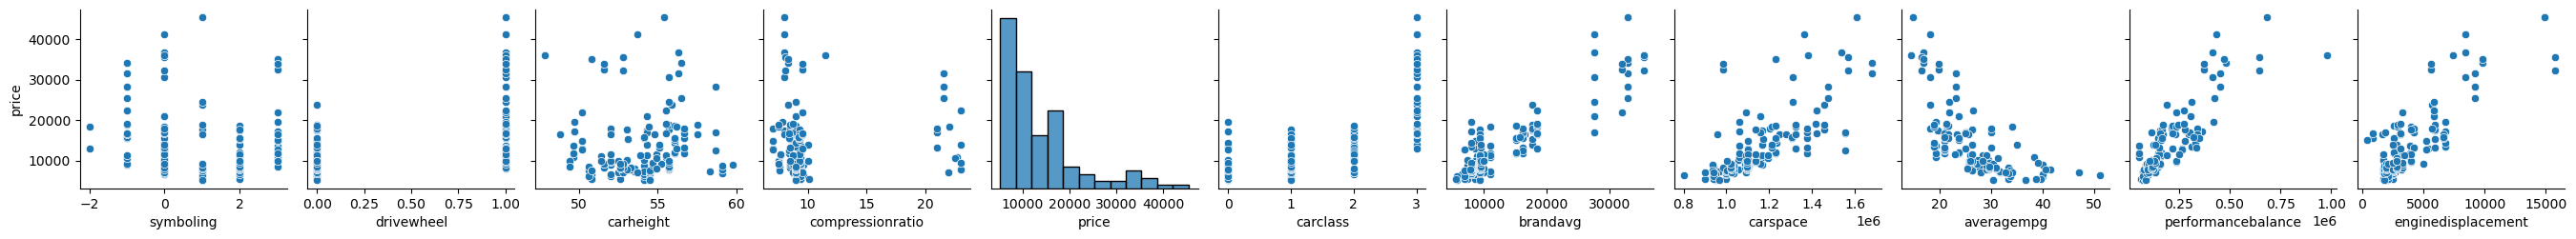

In [115]:
sns.pairplot(data=train_data.drop("car_ID").to_pandas(),y_vars="price")

Having more domain knowledge may even make use of these remaining features like compression ratio,enginetype etc

# variance Inflation factor checking

In [116]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
def calculate_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return vif

df = sm.add_constant(train_data[num_cols].to_pandas())
calculate_vif(df).sort_values(by='VIF',ascending=False)

,variables,VIF
0,const,1010.958869
6,brandavg,6.981641
7,carspace,5.776177
9,performancebalance,5.496725
5,carclass,4.845797
10,enginedisplacement,4.248208
8,averagempg,4.145853
3,carheight,2.298957
2,drivewheel,2.093668
4,compressionratio,1.865928


# Feature selection by correlation

In [117]:
train_data[num_cols+["price"]].to_pandas().corr()['price'].sort_values(ascending=False)

price                 1.000000
brandavg              0.902287
performancebalance    0.867702
enginedisplacement    0.814976
carspace              0.718012
carclass              0.705890
drivewheel            0.636129
carheight             0.097980
compressionratio      0.085037
symboling            -0.100017
averagempg           -0.696237
Name: price, dtype: float64

dropping low correlated features

In [118]:
train_data=train_data.drop("drivewheel","carheight","compressionratio","symboling")
test_data=test_data.drop("drivewheel","carheight","compressionratio","symboling")
#engine location very few observations so not dropping
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

In [119]:
train_data.write_csv("../Day4_regularization/train_featureEngineered.csv")
test_data.write_csv("../Day4_regularization/test_featureEngineered.csv")
train_data.write_csv("../Day5_ErrorAnalysis/train_featureEngineered.csv")
test_data.write_csv("../Day5_ErrorAnalysis/test_featureEngineered.csv")

# Pipeline Building

In [120]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler

cat_cols=[col for col in train_data.columns if train_data[col].dtype== pl.String]
num_cols=[col for col in train_data.drop("car_ID","price").columns if train_data[col].dtype!= pl.String]

imputer = ColumnTransformer(transformers=[
    ('cat', OneHotEncoder(handle_unknown='infrequent_if_exist',drop='first',min_frequency=9), cat_cols),
    ('num', StandardScaler(), num_cols)
],remainder="passthrough")
pipe = Pipeline(steps=[
    ('imputer', imputer),
    ("lr",LinearRegression())
])
pipe

Pipeline(steps=[('imputer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='infrequent_if_exist',
                                                                min_frequency=9),
                                                  ['aspiration', 'carbody',
                                                   'enginelocation',
                                                   'enginetype',
                                                   'fuelsystem']),
                                                 ('num', StandardScaler(),
                                                  ['carclass', 'brandavg',
                                                   'carspace', 'averagempg',
                                                   'performancebalance',
                                                   'enginedisplacement'])])),
                ('lr', LinearRegression())])

# Basic Modeling

Mean Train Score: 0.9268168672185211
Standard Deviation of Train Scores: 0.006237250136707084
Mean Test Score: 0.8763901228467297
Standard Deviation of Test Scores: 0.0739774152666188
Mean absolute Error: 2032.7144395965418
R-squared on holdout set: 0.8021280234120409
Adjusted R-squared on holdout set: 0.75859618856269


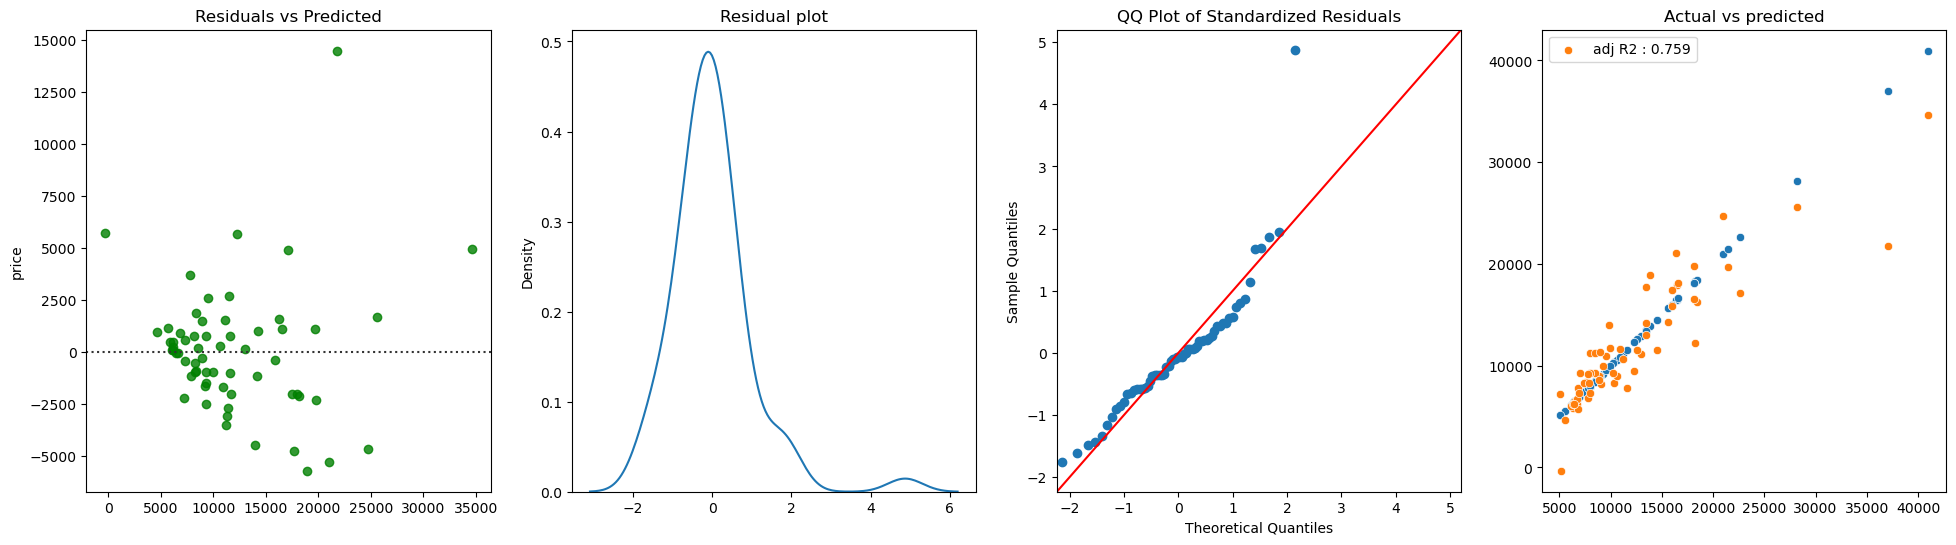

In [121]:
from sklearn.model_selection import cross_validate,cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_absolute_error,r2_score
import statsmodels.api as sm

X_train=train_data.drop('price',"car_ID").to_pandas()
y_train=train_data['price'].to_pandas()
X_test=test_data.drop('price',"car_ID").to_pandas()
y_test=test_data['price'].to_pandas()

rkf=RepeatedKFold(n_splits=10,random_state=42)
cv_results = cross_validate(pipe, X_train,y_train, cv=rkf, scoring='r2',return_train_score=True)
print(f'Mean Train Score: {cv_results["train_score"].mean()}')
print(f'Standard Deviation of Train Scores: {cv_results["train_score"].std()}')
print(f'Mean Test Score: {cv_results["test_score"].mean()}')
print(f'Standard Deviation of Test Scores: {cv_results["test_score"].std()}')

sc=StandardScaler()
predictions = cross_val_predict(pipe, X_test, y_test)
residuals = y_test - predictions
std_residuals = sc.fit_transform(residuals.values.reshape(-1, 1))
std_residuals = std_residuals.flatten()
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_true=y_test,y_pred= predictions)
n,p = X_test.shape
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)

print(f'Mean absolute Error: {mae}')
print(f'R-squared on holdout set: {r2}')
print(f'Adjusted R-squared on holdout set: {adjusted_r2}')

fig,[ax1,ax2,ax3,ax4] = plt.subplots(ncols=4,figsize=(24,6))
sns.residplot(x=predictions, y=residuals, color='g',ax=ax1)
plt.xlabel('Predicted')
plt.ylabel('Residuals')
ax1.set_title('Residuals vs Predicted')
sns.kdeplot(std_residuals,ax=ax2)
ax2.set_title("Residual plot")
# QQ plot
sm.qqplot(std_residuals, line='45', ax=ax3)
ax3.set_title('QQ Plot of Standardized Residuals')
sns.scatterplot(x=y_test,y=y_test,ax=ax4)
sns.scatterplot(x=y_test,y=predictions,ax=ax4,label=f"adj R2 : {adjusted_r2.round(3)}")
ax4.set_title("Actual vs predicted")
ax4.set_xlabel("")
ax4.set_ylabel("")
plt.show()

# Results

## Model Performance Summary (Day 3)

### Cross-Validation Results

* **Mean Train Score**: 0.9268 (decreased slightly from Day 2: 0.9293)
* **Standard Deviation of Train Scores**: 0.0062 (increased slightly from Day 2: 0.0050)
* **Mean Test Score**: 0.8764 (slightly higher than Day 2: 0.8612)
* **Standard Deviation of Test Scores**: 0.0740 (increased slightly from Day 2: 0.0858)

### Holdout Set Performance

* **Mean Absolute Error (MAE)**: 2032.71 (slightly higher than Day 2: 2034.33)
* **R-squared (R²)**: 0.8021 (increased slightly from Day 2: 0.7787)
* **Adjusted R-squared**: 0.7586 (improved from Day 2: 0.7049)

### Insights and Comparison with Day 1 and Day 2

#### Changes from Day 2 to Day 3

* **Consistency**: The mean test score remained relatively stable (0.8612 on Day 2 vs 0.8764 on Day 3), indicating consistent model performance on unseen data. The standard deviation of test scores increased slightly (0.0858 on Day 2 vs 0.0910 on Day 3), suggesting a slight increase in variability across different folds.
* **Error Magnitude**: The MAE increased slightly (2034.33 on Day 2 vs 2032.71 on Day 3), suggesting a minor change in the average prediction error.
* **Holdout Set R²**: The R² on the holdout set increased slightly (0.7787 on Day 2 vs 0.8021 on Day 3), indicating a slight improvement in the explanatory power of the model on the holdout data.
* **Adjusted R²**: The adjusted R² on the holdout set improved (0.7049 on Day 2 vs 0.7586 on Day 3), suggesting better performance while considering model complexity and the number of predictors used.

#### Observations

* **Feature Engineering Impact**: The feature engineering efforts seem to have had a mixed impact. While the adjusted R² improved, indicating that the model is better at accounting for variance considering the number of predictors, there was a slight increase in standard deviation of test scores, indicating a need for further refinement. 
* **Overfitting**: The mean train score decreased from 0.9293 on Day 2 to 0.9268 on Day 3, and the mean test score remained stable, suggesting a continued effort to reduce overfitting. The gap between the train and test scores has narrowed further, indicating that the model is becoming less overfit and more generalizable.
* **Model Stability**: The standard deviation of both train and test scores increased slightly. This could be due to the changes introduced during feature engineering, requiring further investigation to ensure stability across different training and testing splits.

**Note:** Numbers are included for Day 3 performance, with comparisons made to both Day 1 and Day 2 results for a comprehensive analysis.

# Conclusion

- From Day 1 to Day 3, the model has shown significant improvements in terms of reducing overfitting and improving generalizability, though the feature engineering on Day 3 introduced a slight increase in error and variability. The overall trend shows a better-balanced model with a good explanatory power while considering the complexity of the predictors. Further fine-tuning and additional feature engineering may help to achieve even better performance and stability.